In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os 
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG19

In [3]:
path = '/content/drive/MyDrive/Dataset_Hockey/'
img_size = 160
num_classes = 2
frame_per_video = 30

In [4]:
number_video_train = len(os.listdir(path + 'train/NonFight')) + len(os.listdir(path + 'train/Fight'))
fights_train = np.zeros((number_video_train, frame_per_video, img_size, img_size, 3), dtype=np.float32)
labels_train = []

fights_train.shape

(800, 30, 160, 160, 3)

In [5]:
number_video_valid = len(os.listdir(path + 'valid/NonFight')) + len(os.listdir(path + 'valid/Fight'))
fights_valid = np.zeros((number_video_valid, frame_per_video, img_size, img_size, 3), dtype=np.float32)
labels_valid = []

fights_valid.shape

(200, 30, 160, 160, 3)

In [6]:
from tensorflow.keras.applications.vgg19 import preprocess_input

def get_frames(filename):
  frames = np.zeros((frame_per_video, img_size, img_size, 3))

  cap = cv2.VideoCapture(filename)

  ret, frame = cap.read()
  if ret == False:
    return

  i = 0

  while i < frame_per_video:
    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
    img = preprocess_input(img)
    img = img.astype(np.float32) / 255.0 

    frames[i][:] = img

    ret, frame = cap.read()
    if ret == False:
      return

    i += 1

  return frames

In [ ]:
# Test get_frames(filename)

a = get_frames('/content/drive/MyDrive/Dataset_Hockey/train/Fight/fi80_xvid.avi')

for i in a:
  plt.imshow(i)
  plt.show()

In [7]:
def load(mod):
    classes = ['NonFight','Fight']

    i = 0

    for cls in classes:
        local_path = f'{path}{mod}/{cls}'
        for file in os.listdir(local_path):
            videos = get_frames(f'{local_path}/{file}')
            # print(f'{local_path}/{file}')
            if mod == 'train':
                fights_train[i][:][:] = videos
                i += 1

                if cls == classes[0]:
                    labels_train.append(0)
                else:
                    labels_train.append(1)
                        
            elif mod == 'valid':
                fights_valid[i][:][:] = videos
                i += 1
                if cls == classes[0]:
                    labels_valid.append(0)
                else:
                    labels_valid.append(1)

In [8]:
load('train')

In [9]:
load('valid')

In [10]:
import tensorflow.keras as k

y_train = k.utils.to_categorical(labels_train)
y_valid = k.utils.to_categorical(labels_valid)

In [11]:
base_model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape = (img_size, img_size, 3)
)

base_model.trainable = False

In [12]:
data_augmentation = k.Sequential([
    k.layers.RandomRotation(0.2),  
    k.layers.RandomZoom(0.1),  
    k.layers.RandomTranslation(0.1, 0.1),  
    k.layers.RandomBrightness(0.1)
])

In [13]:
cnn = k.Sequential([
    data_augmentation,
    base_model,
    k.layers.Flatten(),
])

In [14]:
model = k.Sequential([
    k.layers.TimeDistributed(cnn,  input_shape=(frame_per_video, img_size, img_size, 3)),
    k.layers.LSTM(frame_per_video, return_sequences=True),

    k.layers.TimeDistributed(k.layers.Dense(90, activation='relu')),
    k.layers.Dropout(0.1),

    k.layers.GlobalAveragePooling1D(),

    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 12800)        20024384  
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 30, 30)            1539720   
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 90)           2790      
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 30, 90)            0         
                                                                 
 global_average_pooling1d (G  (None, 90)               0         
 lobalAveragePooling1D)                                          
                                                      

In [15]:
# adam = k.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
adam = k.optimizers.Adam(learning_rate=0.000125, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

In [16]:
earlyStopping = k.callbacks.EarlyStopping(monitor='val_loss', patience=8,min_delta=1e-5, verbose=1, mode='min')
reduce_learning_rate_loss = k.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=1, verbose=2,factor=0.5,min_lr=0.0000001)

In [17]:
r = model.fit(
    fights_train, y_train,
    batch_size = 3,
    epochs = 20,
    validation_data = (fights_valid, y_valid),
    # callbacks=[earlyStopping, reduce_learning_rate_loss],
    callbacks=[earlyStopping],
    verbose = 1,
)

Epoch 1/20
267/267 [==============================] - 110s 343ms/step - loss: 0.5114 - accuracy: 0.7700 - val_loss: 0.2740 - val_accuracy: 0.9100
Epoch 2/20
267/267 [==============================] - 84s 315ms/step - loss: 0.3107 - accuracy: 0.8838 - val_loss: 0.2521 - val_accuracy: 0.9250
Epoch 3/20
267/267 [==============================] - 84s 315ms/step - loss: 0.2695 - accuracy: 0.9038 - val_loss: 0.2805 - val_accuracy: 0.9200
Epoch 4/20
267/267 [==============================] - 84s 314ms/step - loss: 0.2557 - accuracy: 0.9062 - val_loss: 0.2899 - val_accuracy: 0.8800
Epoch 5/20
267/267 [==============================] - 84s 316ms/step - loss: 0.2309 - accuracy: 0.9250 - val_loss: 0.5467 - val_accuracy: 0.7150
Epoch 6/20
267/267 [==============================] - 84s 314ms/step - loss: 0.2261 - accuracy: 0.9250 - val_loss: 0.3163 - val_accuracy: 0.8550
Epoch 7/20
267/267 [==============================] - 84s 315ms/step - loss: 0.2209 - accuracy: 0.9262 - val_loss: 0.8539 - val_a

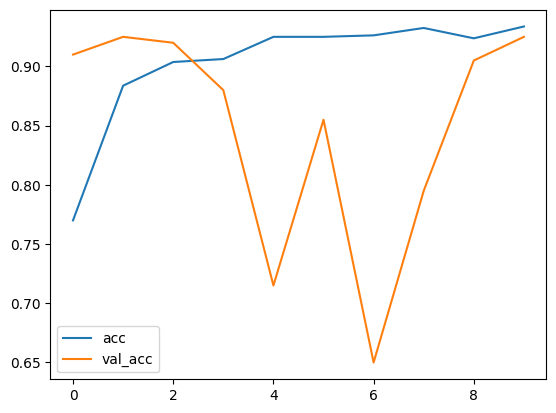

In [18]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

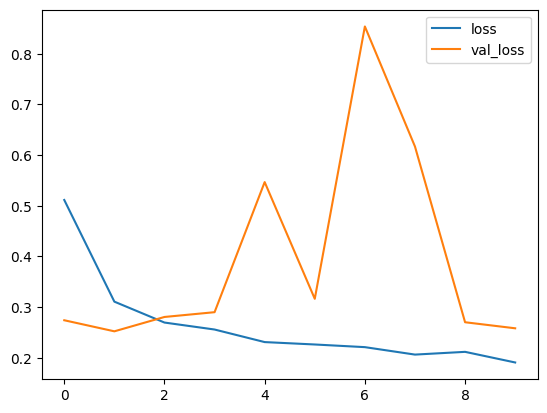

In [20]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [19]:
model.save('/content/drive/MyDrive/hockey_10_epochs_925.h5')